In [115]:
from feature_engine.imputation import MeanMedianImputer
import pickle
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, log_loss
from sklearn.preprocessing import label_binarize

from datetime import datetime, timedelta
import holidays

from tqdm import tqdm_notebook, tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

seed = 42
np.random.seed(seed)

In [116]:
def calculate_auuq(y_true, y_pred_proba):
    """
    Функция для вычисления Area Under Uplift Curve (AUUQ).
    
    Параметры:
    y_true (numpy.ndarray или pandas.Series): Истинные ответы, shape (n_samples,)
    y_pred_proba (numpy.ndarray): Предсказанные вероятности, shape (n_samples,)
    
    Возвращает:
    float: Значение AUUQ
    """
    # Сортируем по вероятностям
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    
    try:
        # Используем iloc для позиционного индексирования
        y_true_sorted = y_true.iloc[sorted_indices]
    except KeyError as e:
        print(f"KeyError encountered: {e}")
        return None  # Или обработайте это как нужно
    
    # Вычисляем кумулятивные суммы
    cumulative_gain = np.cumsum(y_true_sorted)
    
    # Вычисляем AUUQ
    total_positive = np.sum(y_true)
    
    if total_positive == 0:  # Проверка на деление на ноль
        return 0.0
    
    auuq = cumulative_gain / total_positive
    
    return np.mean(auuq)

def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам точности, F1, полноты, точности, ROC AUC, Gini, Log Loss и AUUQ.
    
    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """
    
    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")
    
    results = []
    
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        
        # Вычисление предсказания вероятностей для метрик ROC AUC и Gini
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            roc_auc = roc_auc_score(Y, y_proba)
            gini = 2 * roc_auc - 1
            logloss = log_loss(Y, y_proba)
            auuq = calculate_auuq(pd.Series(Y), y_proba)  # Преобразуем Y в Series для совместимости
        else:
            roc_auc = None
            gini = None
            logloss = None
            auuq = None
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Recall': recall,
            'Precision': precision,
            'ROC AUC': roc_auc,
            'Gini': gini,
            'Log Loss': logloss,
            'AUUQ': auuq
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [117]:
def plot_roc_curve(model, X, Y):
    """
    Функция для построения ROC кривой и вывода метрики AUC.
    
    Параметры:
    model: обученная модель, которая поддерживает метод predict_proba
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    """
    # Получение предсказанных вероятностей для положительного класса (1)
    y_proba = model.predict_proba(X)[:, 1]

    # Вычисляем ROC кривую и AUC
    fpr, tpr, thresholds = roc_curve(Y, y_proba)
    roc_auc = roc_auc_score(Y, y_proba)

    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия для случайного угадывания
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [1]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

NameError: name 'pd' is not defined

In [ ]:
def process_dates(df, col_data):
    # Преобразуем серию в формат datetime
    dates = pd.to_datetime(df[col_data])

    # Определяем выходной или рабочий день (0 - рабочий, 1 - выходной)
    df['is_weekend'] = dates.dt.dayofweek >= 5  # Суббота и воскресенье
    df['is_weekend'] = df['is_weekend'].astype(int)  # Преобразуем в 0 и 1

    # Определяем время года (1 - зима, 2 - весна, 3 - лето, 4 - осень)
    df['season'] = np.select(
        [
            (dates.dt.month == 12) | (dates.dt.month <= 2),  # Декабрь, Январь, Февраль
            (dates.dt.month >= 3) & (dates.dt.month <= 5),   # Март, Апрель, Май
            (dates.dt.month >= 6) & (dates.dt.month <= 8),   # Июнь, Июль, Август
            (dates.dt.month >= 9) & (dates.dt.month <= 11)   # Сентябрь, Октябрь, Ноябрь
        ],
        [1, 2, 3, 4]
    )

    # Определяем день недели (1 - понедельник, ..., 7 - воскресенье)
    df['weekday'] = dates.dt.dayofweek + 1

    # Определяем номер месяца
    df['month'] = dates.dt.month

    # Определяем номер недели в месяце
    df['week_of_month'] = ((dates.dt.day - 1) // 7) + 1

    return df

# Анализ данных

## Просмотр

In [120]:
data = pd.read_csv('train_E.csv')
data

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,NaN,1.0,Representatives,123.0,Первичная ДК,1,14.0,147000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-07-04,0,1
1,NaN,1.0,Offline,43.0,Airports,0,1.0,120000.0,PLT,0.0,...,1.0,0,1.0,0.0,-1.2,1.0,0,2024-06-06,0,1
2,0.0,1.0,Web,2.0,seo,0,NaN,15000.0,PLT,0.0,...,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-21,1,1
3,0.0,1.0,MB,2.0,One Click Offer,0,91.0,260000.0,PLT,0.0,...,1.0,0,NaN,1.0,-1.2,1.0,0,2024-05-23,0,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,1,1.0,130000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-28,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,NaN,1.0,Representatives,123.0,Первичная ДК,1,34.0,95000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-13,1,1
297246,NaN,1.0,Representatives,123.0,Первичная ДК,1,1.0,83000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,NaN,0,2024-07-08,0,1
297247,0.0,1.0,Mobile Warm,2.0,TOOS cor clients,0,2.0,170000.0,PLT,0.0,...,1.0,0,NaN,0.0,1.0,1.0,0,2024-06-12,0,1
297248,0.0,1.0,Representatives,123.0,Первичная ДК,1,5.0,15000.0,PLT,0.0,...,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-02,1,1


In [121]:
data.isna().sum()

application_1             115128
cc_1                       18235
cc_2                       10479
cc_3                       10479
cc_4                       10482
                           ...  
partner_24                 40468
application_16                 0
retro_date                     0
successful_utilization         0
treatment                      0
Length: 152, dtype: int64

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297250 entries, 0 to 297249
Columns: 152 entries, application_1 to treatment
dtypes: float64(131), int64(17), object(4)
memory usage: 344.7+ MB


## Очистка

In [123]:
data_del_par, nan_par_nums, nana_par_obj = [], [], []


for i in data.isnull().sum().items():
    if i[-1] > len(data) * 0.5:
        data_del_par.append(i[0])
        print(i)
    if 0 < i[-1] <= len(data) * 0.5 and data[i[0]].dtype != object:
        nan_par_nums.append(i[0])
    if 0 < i[-1] <= len(data) * 0.5 and data[i[0]].dtype == object:
        nana_par_obj.append(i[0])

('feature_6', 175616)
('feature_8', 167896)
('feature_11', 157503)
('partner_15', 198146)
('cc_13', 202507)
('cc_14', 185053)
('bki_20', 224048)
('feature_15', 167896)
('feature_16', 278988)
('bki_22', 179233)
('feature_19', 158588)
('cc_17', 158588)
('bki_30', 169674)
('bki_31', 157294)
('application_12', 217768)
('partner_22', 278303)
('feature_23', 284741)
('bki_40', 169674)
('cc_21', 158588)


In [124]:
data = data.drop(columns=data_del_par)

# imputer = MeanMedianImputer(imputation_method='mean', variables=nan_par_nums)
# imputer.fit(data[nan_par_nums])
# data[nan_par_nums] = imputer.transform(data[nan_par_nums])
for i in nan_par_nums:
    data[i] = data[i].fillna(data[i].mean())
for i in nana_par_obj:
    data[i] = data[i].fillna(data[i].mode()[0])

In [125]:
data.isna().sum()

application_1             0
cc_1                      0
cc_2                      0
cc_3                      0
cc_4                      0
                         ..
partner_24                0
application_16            0
retro_date                0
successful_utilization    0
treatment                 0
Length: 133, dtype: int64

## Object dtype

In [126]:
obj_dt = [i for i in data.columns if data[i].dtype == object]
len(obj_dt)

4

In [127]:
obj_dt

['cc_2', 'cc_4', 'cc_6', 'retro_date']

In [128]:
data[obj_dt[:3]]

,cc_2,cc_4,cc_6
0,Representatives,Первичная ДК,PLT
1,Offline,Airports,PLT
2,Web,seo,PLT
3,MB,One Click Offer,PLT
4,Representatives,Первичная ДК,PLT
...,...,...,...
297245,Representatives,Первичная ДК,PLT
297246,Representatives,Первичная ДК,PLT
297247,Mobile Warm,TOOS cor clients,PLT
297248,Representatives,Первичная ДК,PLT


cc_2
cc_2
Representatives                   212565
MB                                 24975
PreApprove (Mobile Applicants)     16500
Mobile Warm                        14573
Web                                13095
Offline                             7591
BAF (Приведи друга)                 5191
Down-sell                           2752
Mobile Cold                            5
Other                                  3
Name: count, dtype: int64
['Representatives' 'Offline' 'Web' 'MB' 'Down-sell' 'Mobile Warm'
 'PreApprove (Mobile Applicants)' 'BAF (Приведи друга)' 'Mobile Cold'
 'Other']
10


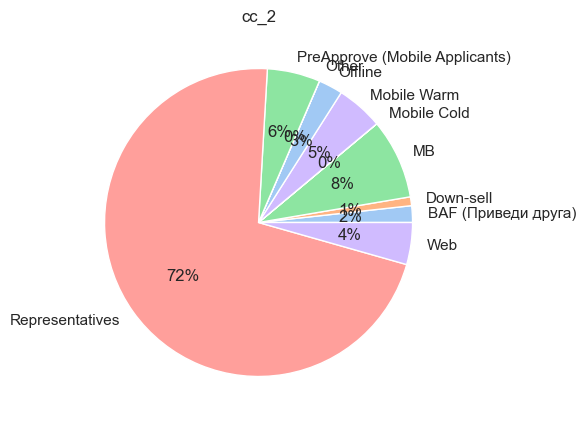


cc_4
cc_4
Первичная ДК       129549
Перевыпуск ДК       29989
Multitask           15941
One Click Offer      9183
Heavy                8413
                    ...  
smm                    11
afterfilling           10
Internet                7
Cold                    5
Installment             1
Name: count, Length: 75, dtype: int64
['Первичная ДК' 'Airports' 'seo' 'One Click Offer' 'Multitask'
 'Перевыпуск ДК' 'Cash Loan' 'Other' 'Установка приложения' 'SIM'
 'Доп.карта ДК' 'TOOS cor clients' 'Другое ДК' 'Heavy' 'affilate'
 'context' 'CCR Rescore (PA)' 'Heavy xsell' 'Страхование' 'Junior ДК'
 'Фейк встречи POS' 'TOOS afterfilling' 'TOOS other' 'Сразу полные'
 'LON Rescore (PA)' 'display' 'xsell_income_call_new' 'Rosbank'
 'COR Clients (PA)' 'pos_tcb_online' 'Инвестиции' 'Light'
 'POS Rescore (PA)' 'TOOS pos_trigger' 'other int' 'Phone' 'SME' 'sms'
 'Direct Car Loan' 'Partners' 'web_lk_organic' 'кошелек'
 'CC Attrition (PA)' 'cpa-bloggers' 'Own Retail' 'INV Clients (PA)'
 'TOOS cl_trig

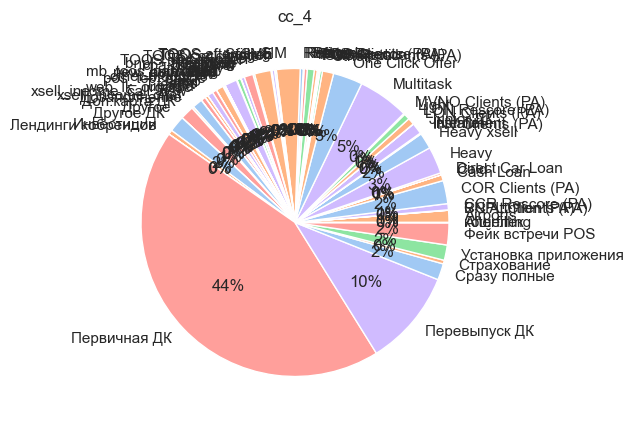


cc_6
cc_6
PLT    293395
AAR      3122
TDC       512
S7C       118
AGC        29
LKC        28
ALC        23
LMC        14
SCB         6
AAC         2
NON         1
Name: count, dtype: int64
['PLT' 'AAR' 'TDC' 'S7C' 'LKC' 'ALC' 'LMC' 'AGC' 'SCB' 'NON' 'AAC']
11


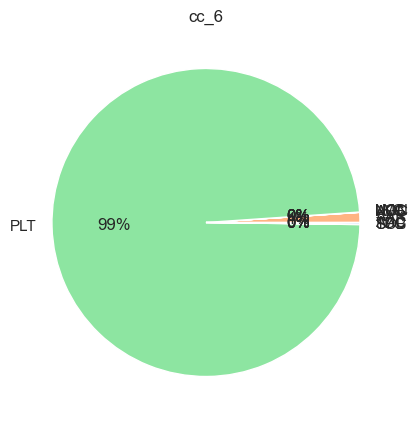


retro_date
retro_date
2024-05-05    5020
2024-05-09    4623
2024-05-06    4466
2024-04-29    4427
2024-06-06    4408
              ... 
2024-07-23    2137
2024-07-09    2093
2024-07-10    1876
2024-07-24    1830
2024-07-17    1825
Name: count, Length: 90, dtype: int64
['2024-07-04' '2024-06-06' '2024-07-21' '2024-05-23' '2024-06-28'
 '2024-06-29' '2024-06-21' '2024-06-09' '2024-06-14' '2024-06-08'
 '2024-05-03' '2024-06-17' '2024-07-18' '2024-05-27' '2024-05-15'
 '2024-06-20' '2024-05-09' '2024-05-01' '2024-05-10' '2024-05-21'
 '2024-05-07' '2024-06-25' '2024-07-15' '2024-06-24' '2024-07-22'
 '2024-05-17' '2024-07-11' '2024-07-03' '2024-06-30' '2024-05-12'
 '2024-06-04' '2024-05-30' '2024-05-24' '2024-07-25' '2024-06-13'
 '2024-05-14' '2024-07-09' '2024-06-16' '2024-04-30' '2024-05-04'
 '2024-06-27' '2024-05-18' '2024-05-08' '2024-07-08' '2024-07-16'
 '2024-06-11' '2024-07-01' '2024-05-31' '2024-05-06' '2024-04-29'
 '2024-07-07' '2024-06-22' '2024-07-19' '2024-06-03' '2024-05-02'
 '20

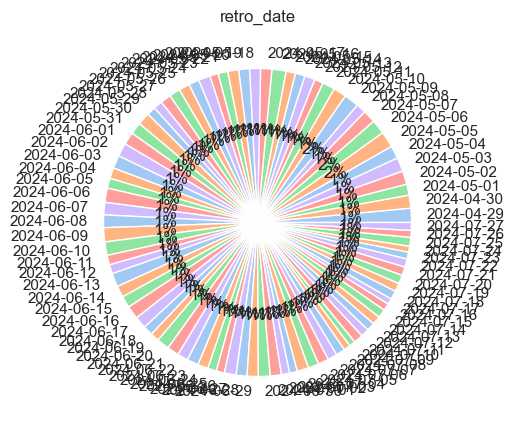

In [129]:
for elem in obj_dt:
    print(elem)
    print(data[elem].value_counts())
    print(data[elem].unique())
    print(len(data[elem].unique()))
    sns.set(rc={'figure.figsize': (5, 5)})
    colors = sns.color_palette('pastel')[0:5]
    labels = sorted(data[elem].map(str).unique())
    dt = np.array([len(data[data[elem] == i]) for i in labels])
    plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
    plt.title(elem)
    plt.show()
    print()

In [130]:
data = data.drop(columns=['cc_6'])

In [131]:
data = process_dates(data, 'retro_date')

## Таргет

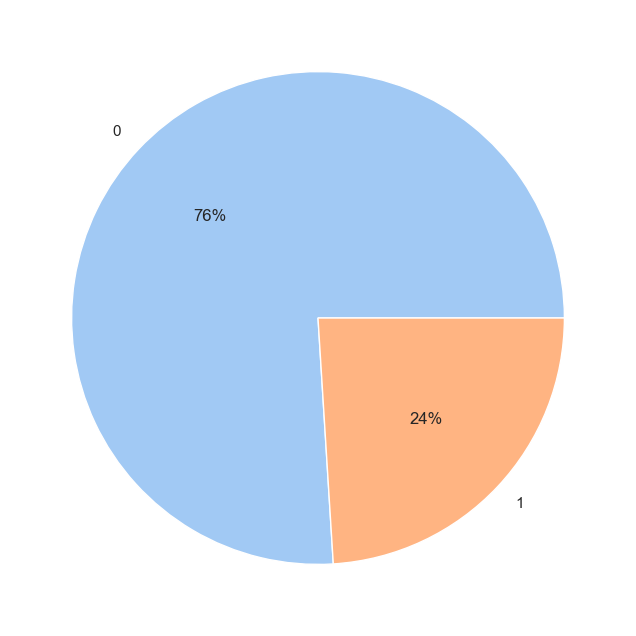

In [132]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['successful_utilization'].unique())
dt = np.array([len(data[data['successful_utilization'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

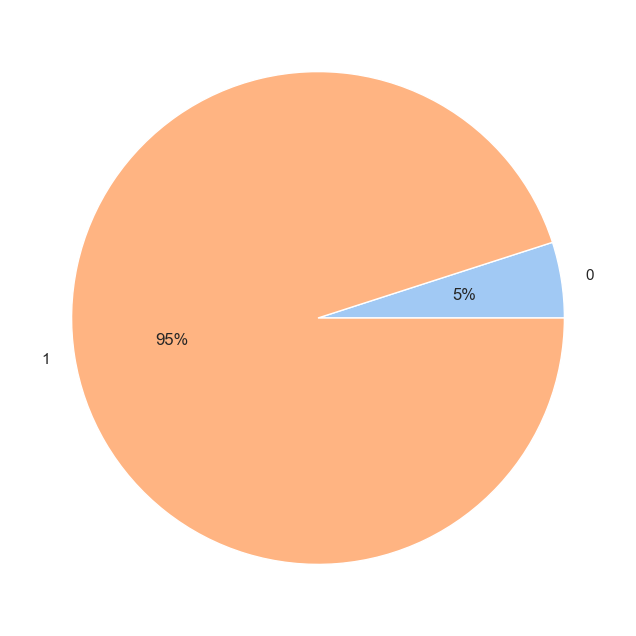

In [133]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['treatment'].unique())
dt = np.array([len(data[data['treatment'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

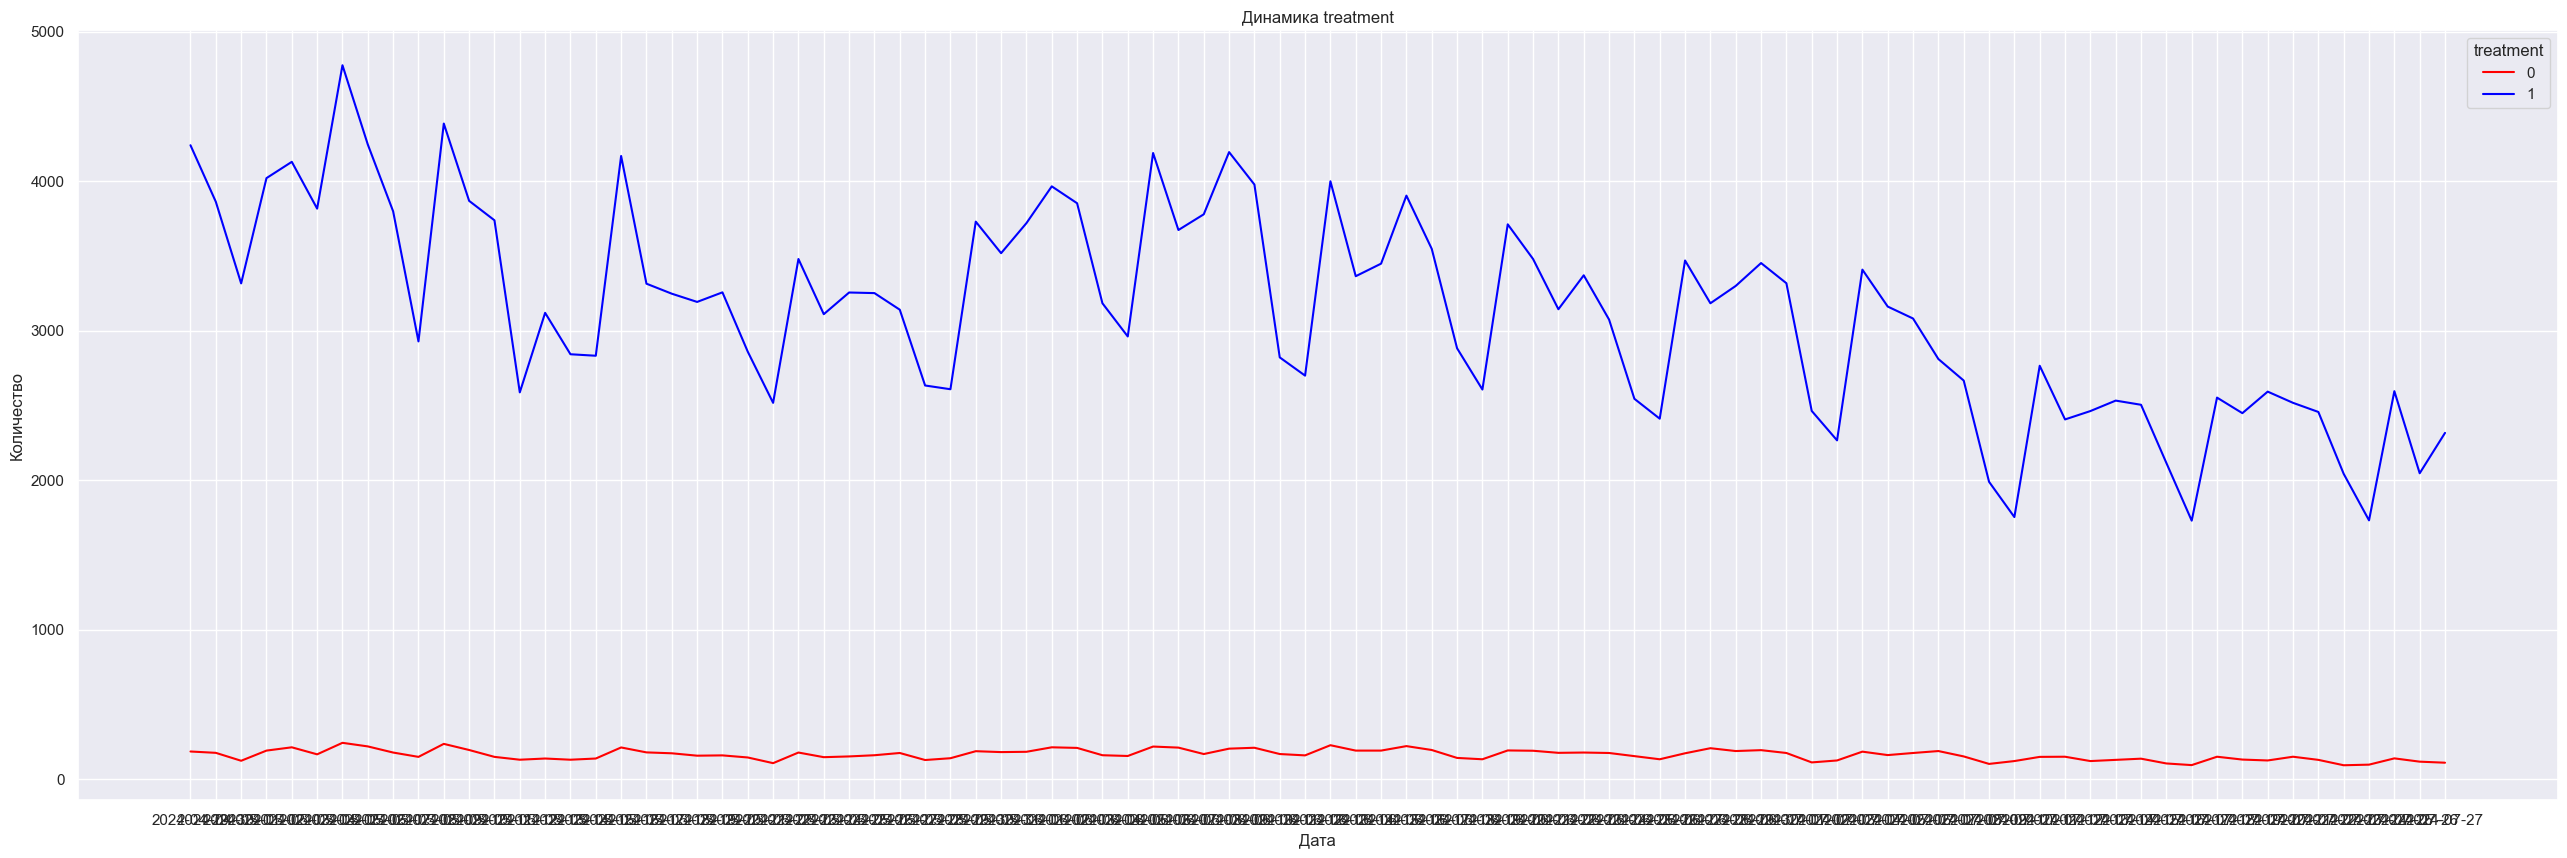

In [134]:
sns.set(rc={'figure.figsize': (32, 10)})

grouped_data = data.groupby(['retro_date', 'treatment']).size().reset_index(name='count')

# Создаем график с двумя линиями
sns.lineplot(data=grouped_data, x='retro_date', y='count', hue='treatment', palette=['red', 'blue'])

# Добавляем заголовок и метки осей
plt.title('Динамика treatment')
plt.xlabel('Дата')
plt.ylabel('Количество')

# Показываем график
plt.show()

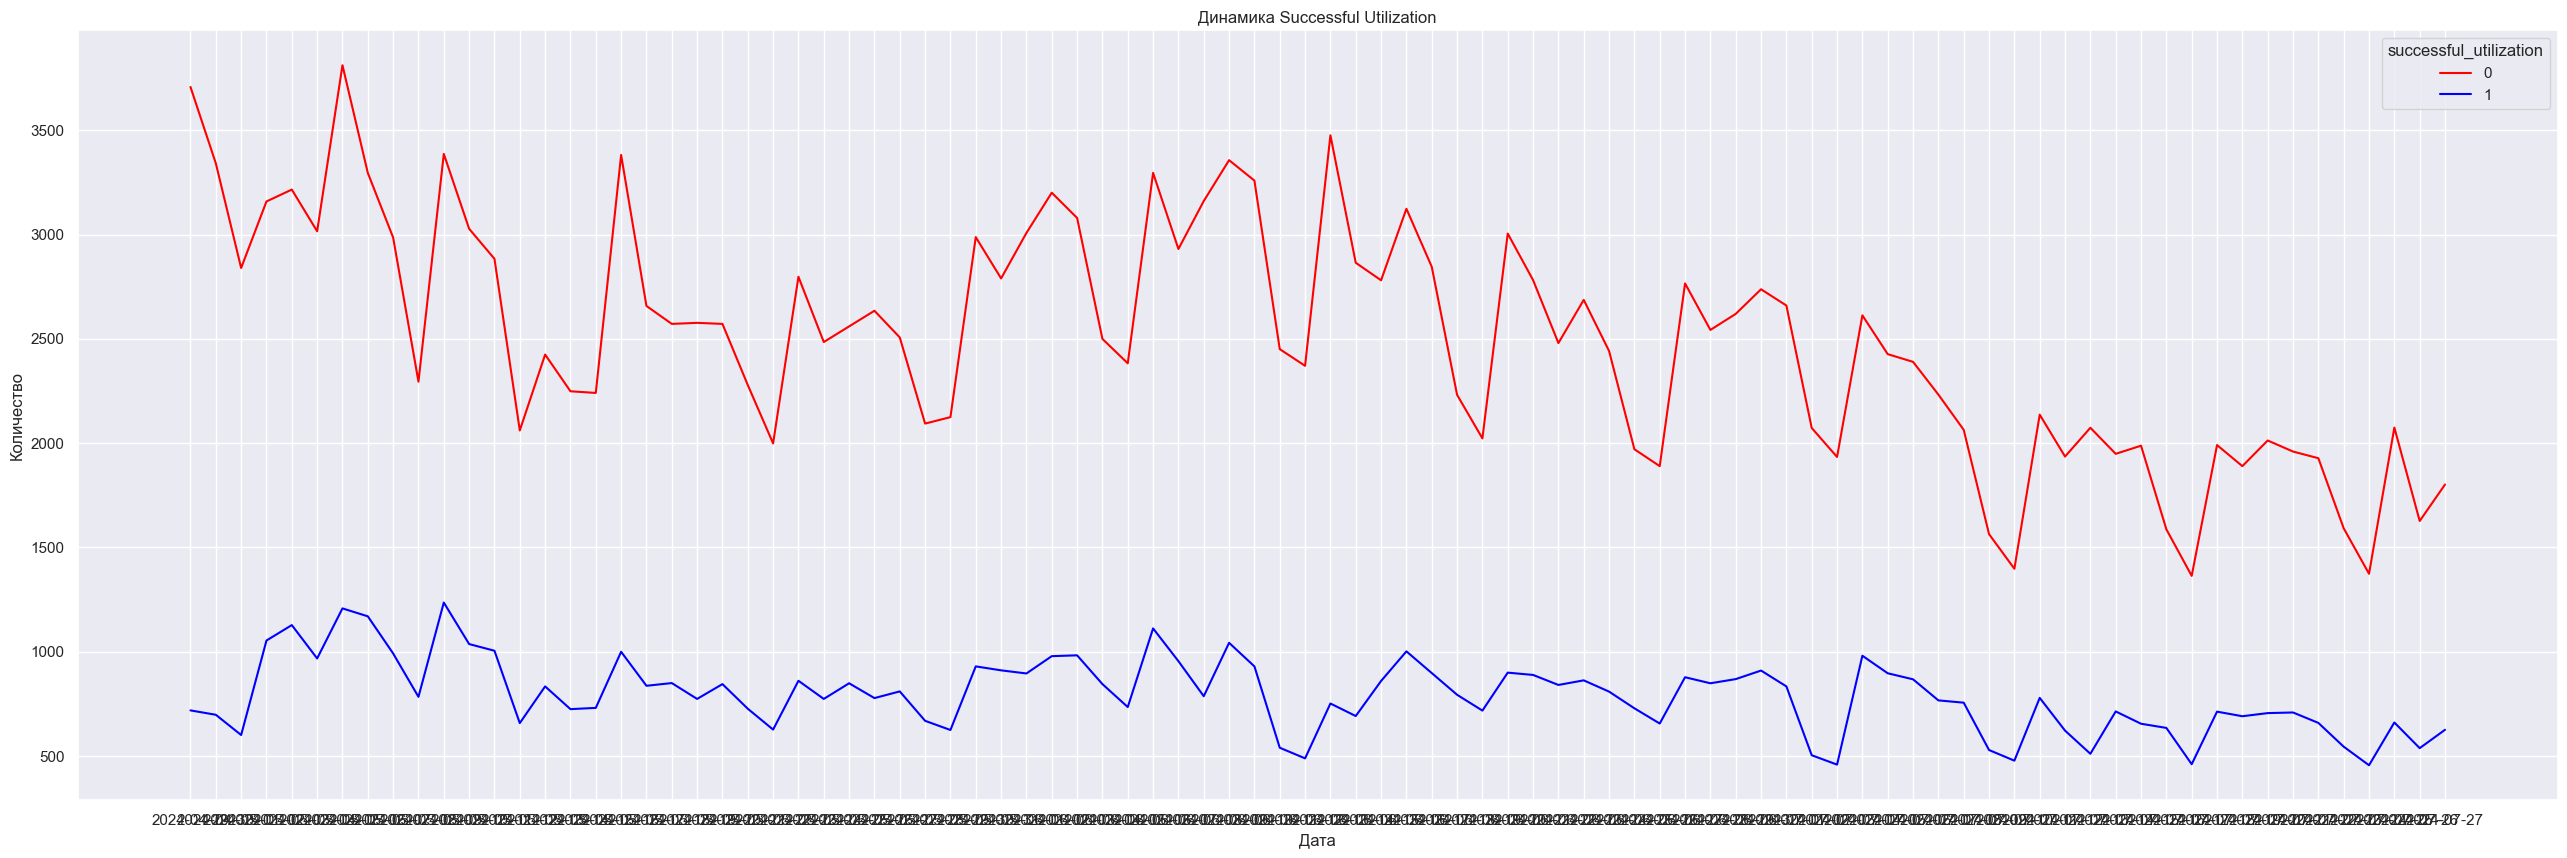

In [135]:
sns.set(rc={'figure.figsize': (32, 10)})

grouped_data = data.groupby(['retro_date', 'successful_utilization']).size().reset_index(name='count')

# Создаем график с двумя линиями
sns.lineplot(data=grouped_data, x='retro_date', y='count', hue='successful_utilization', palette=['red', 'blue'])

# Добавляем заголовок и метки осей
plt.title('Динамика Successful Utilization')
plt.xlabel('Дата')
plt.ylabel('Количество')

# Показываем график
plt.show()

<Axes: xlabel='retro_date', ylabel='count'>

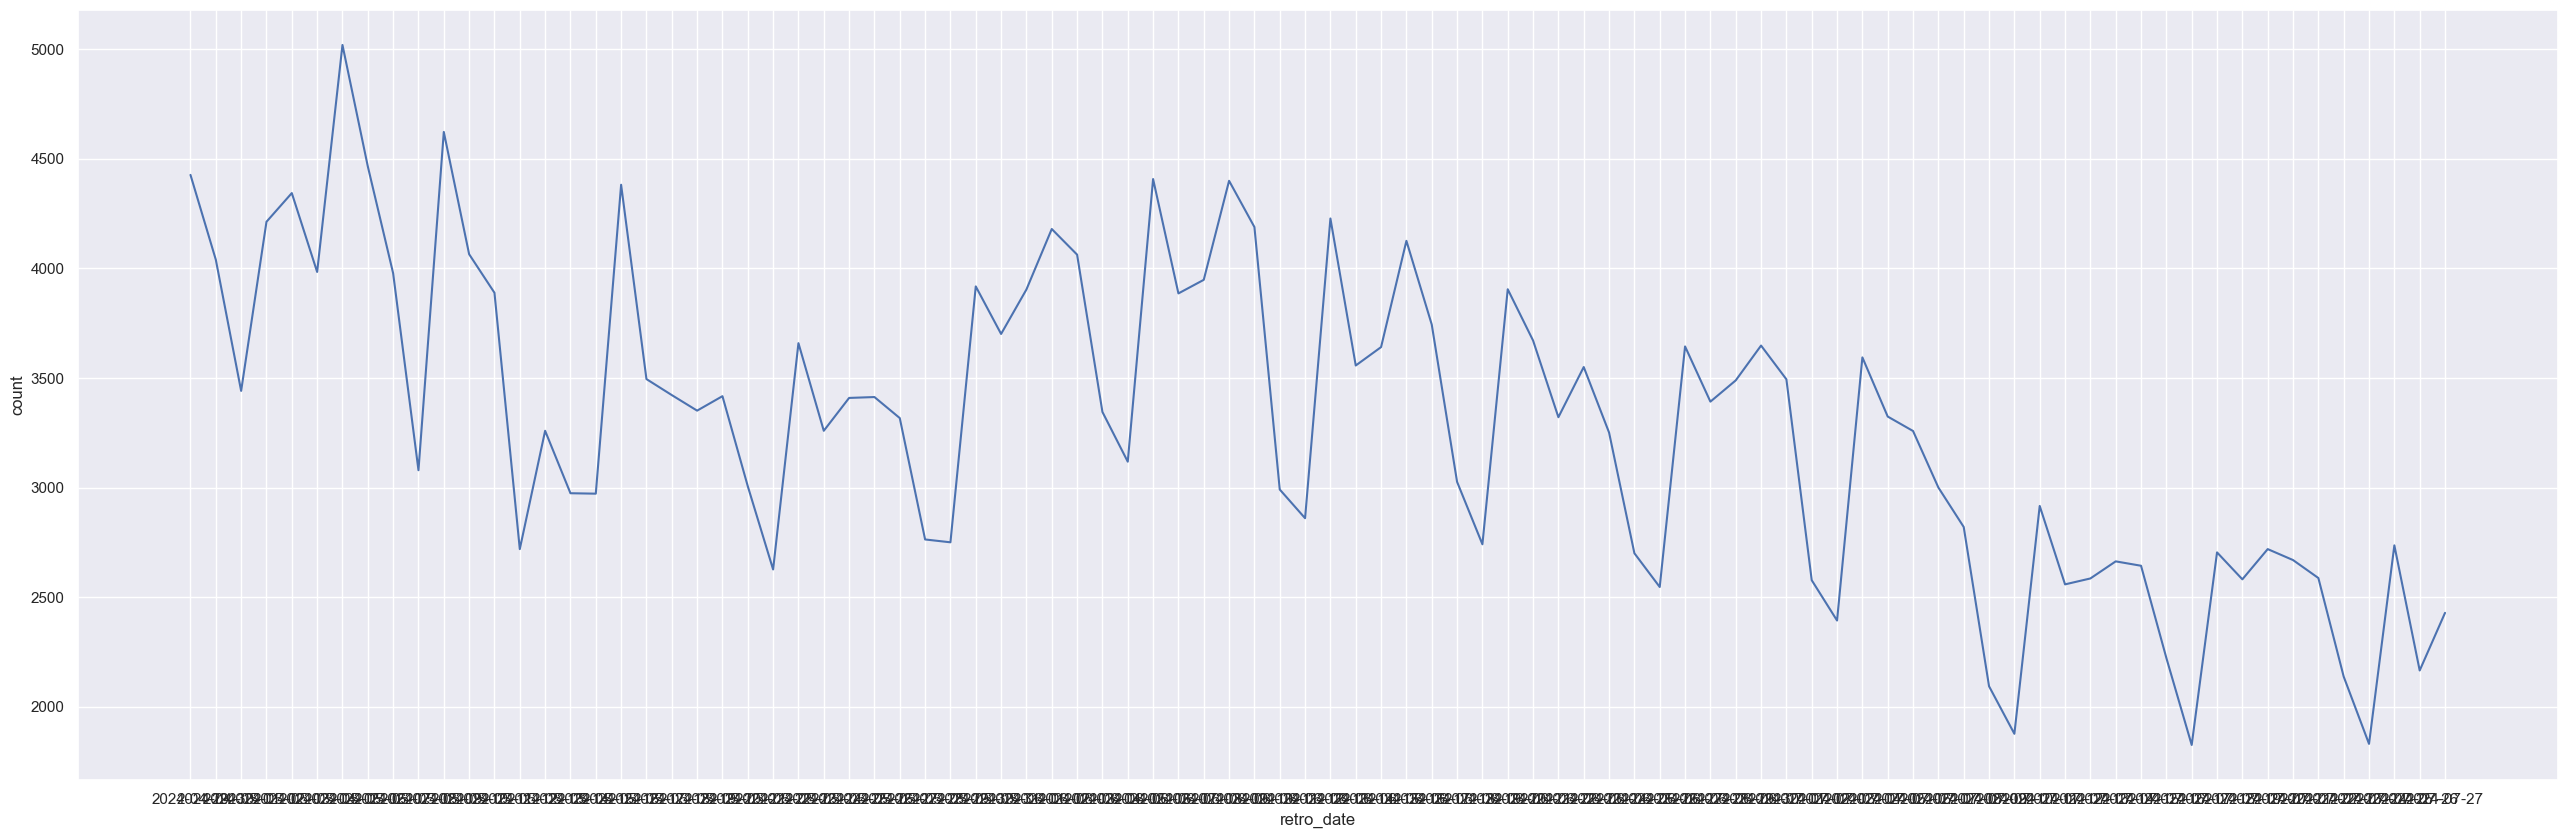

In [136]:
sns.set(rc={'figure.figsize': (32, 10)})

grouped_data = data.groupby(['retro_date']).size().reset_index(name='count')
sns.lineplot(data=grouped_data, x='retro_date', y='count')

## Предабработаем тест

In [137]:
test = pd.read_csv('test_E.csv')

test = process_dates(test, 'retro_date')
test = test.drop(columns=data_del_par + ['cc_6', 'retro_date'])
test_nan_par_nums = []

for i in test.isnull().sum().items():
    if 0 < i[-1] <= len(test) * 0.5 and test[i[0]].dtype != object and i not in nan_par_nums:
        test_nan_par_nums.append(i[0])
    if 0 < i[-1] <= len(test) * 0.5 and test[i[0]].dtype == object:
        nana_par_obj.append(i[0])

# test[nan_par_nums] = imputer.transform(test[nan_par_nums])
for i in test_nan_par_nums + nan_par_nums:
    test[i] = test[i].fillna(test[i].mean())
for i in [j for j in nana_par_obj if j in test.columns.tolist()]:
    test[i] = test[i].fillna(test[i].mode()[0])

In [138]:
test.isna().sum().sort_values()

application_1     0
bki_33            0
application_10    0
bki_32            0
cc_18             0
                 ..
partner_7         0
partner_6         0
bki_7             0
graph_2           0
week_of_month     0
Length: 134, dtype: int64

In [139]:
test

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,feature_2,cc_7,...,feature_25,feature_26,cc_22,partner_24,application_16,is_weekend,season,weekday,month,week_of_month
0,0.000000,1.0,Representatives,80.673442,Первичная ДК,0,6.000000,114641.947942,0.0,0.293391,...,0.00000,0.0,-1.2,1.0,0,0,3,2,6,3
1,0.000000,1.0,Representatives,80.673442,Первичная ДК,0,45.000000,114641.947942,0.0,0.001504,...,0.00000,1.0,-1.2,1.0,0,0,2,4,5,2
2,0.000000,1.0,MB,2.000000,Heavy xsell,0,13.000000,299000.000000,0.0,0.025830,...,0.77374,0.0,-1.2,1.0,0,0,2,4,5,5
3,0.000000,1.0,Representatives,123.000000,SIM,1,158.000000,140000.000000,0.0,0.004579,...,1.00000,0.0,-1.2,1.0,0,0,2,1,5,4
4,0.000000,1.0,Representatives,123.000000,Первичная ДК,0,36.000000,170000.000000,0.0,0.034488,...,1.00000,0.0,-1.2,1.0,0,1,3,6,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,238.774602,1.0,Representatives,123.000000,Multitask,1,21.794422,15000.000000,0.0,0.007608,...,1.00000,0.0,-1.2,1.0,0,0,2,3,5,3
74309,0.000000,1.0,Representatives,123.000000,Первичная ДК,1,12.000000,95000.000000,0.0,0.019465,...,0.77374,0.0,-1.2,1.0,0,0,3,3,7,2
74310,0.000000,1.0,PreApprove (Mobile Applicants),2.000000,Other,0,5.000000,15000.000000,0.0,0.036055,...,0.00000,1.0,-1.2,1.0,1,0,3,4,6,4
74311,0.000000,1.0,Representatives,123.000000,Перевыпуск ДК,1,52.000000,70000.000000,0.0,0.001493,...,1.00000,0.0,-1.2,1.0,0,0,3,1,6,2


## Корреляци и распределение

In [140]:
data = data.drop(columns=['retro_date'])

<Axes: >

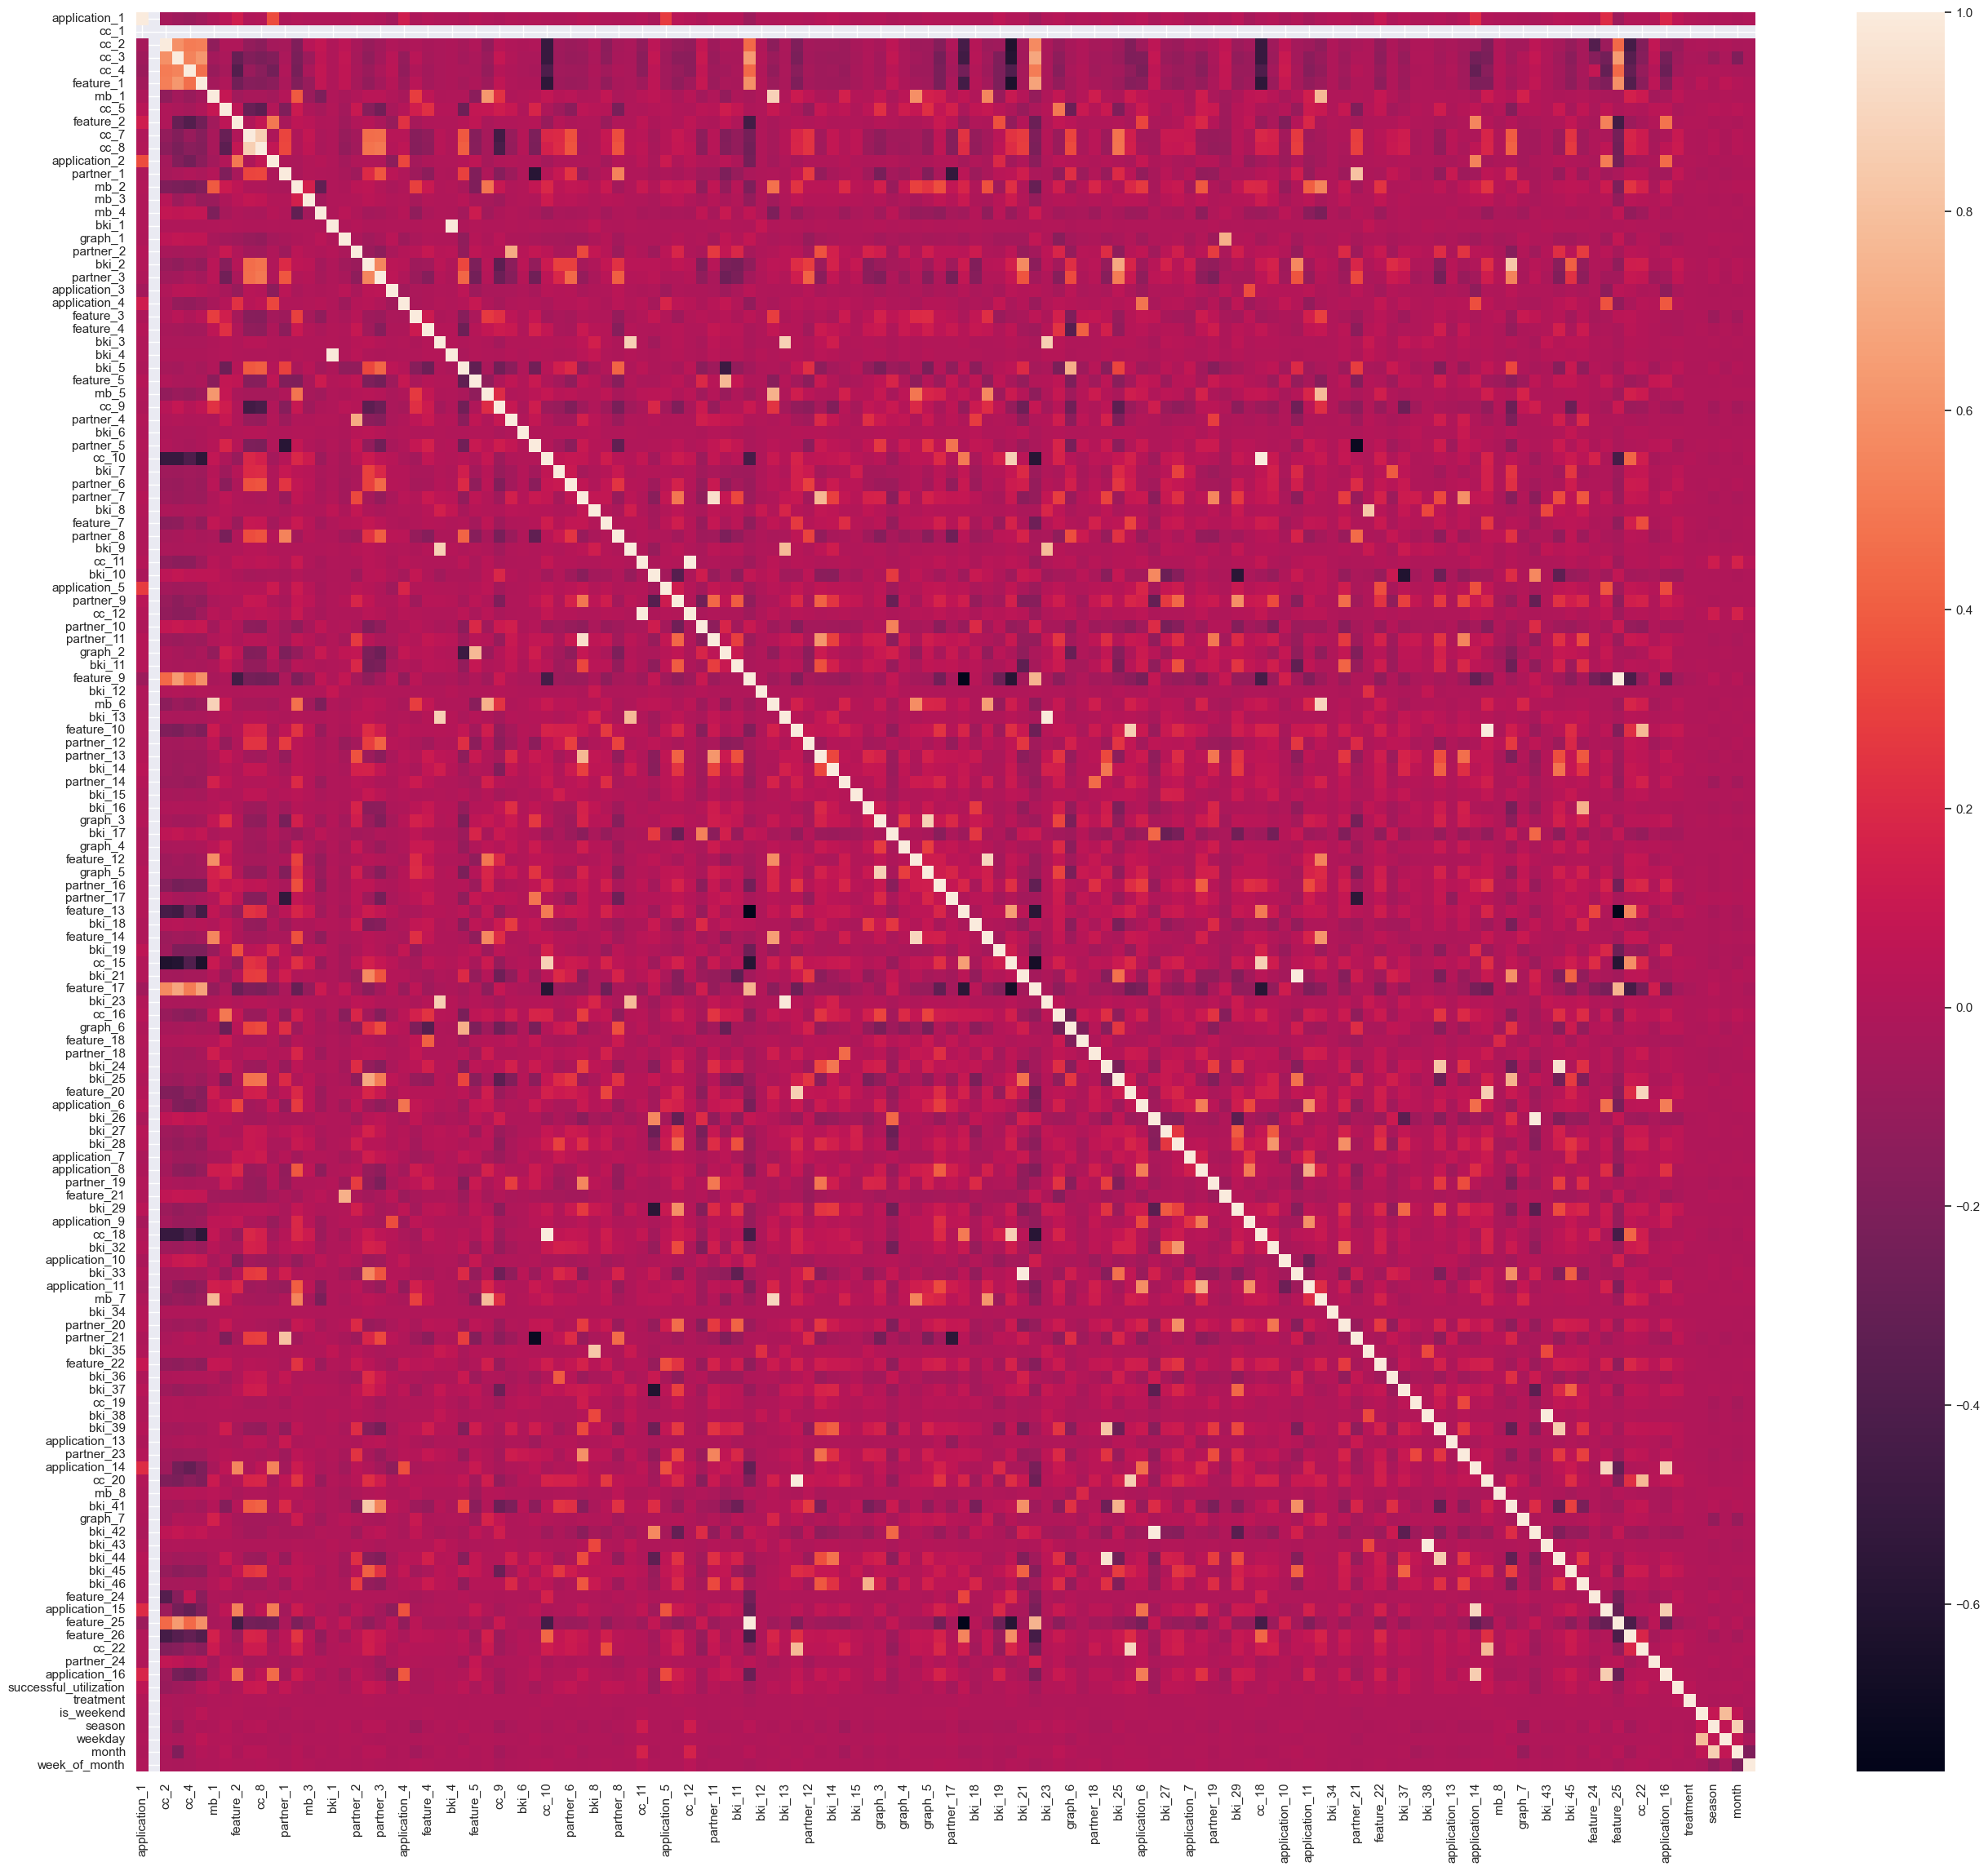

In [141]:
corr_matrix = data.copy()

corr_matrix['cc_4'] = corr_matrix['cc_4'].astype('category')
corr_matrix['cc_4'] = corr_matrix['cc_4'].cat.codes

corr_matrix['cc_2'] = corr_matrix['cc_2'].astype('category')
corr_matrix['cc_2'] = corr_matrix['cc_2'].cat.codes

corr_matrix = corr_matrix.corr()

sns.set(rc={'figure.figsize': (32, 28)})

sns.heatmap(corr_matrix, annot=False)

In [142]:
for i in data.columns:
    if data[i].nunique() < 5:
        print(data[i].unique(), data[i].nunique())
        print(data[i].value_counts())
        print()

[1.] 1
cc_1
1.0    297250
Name: count, dtype: int64

[1 0] 2
feature_1
1    170378
0    126872
Name: count, dtype: int64

[   0 1890  590  990] 4
cc_10
0       227238
590      64090
1890      5212
990        710
Name: count, dtype: int64

[0 1] 2
cc_11
0    167411
1    129839
Name: count, dtype: int64

[0 1] 2
cc_12
0    167411
1    129839
Name: count, dtype: int64

[1.        0.7758051 0.       ] 3
feature_9
1.000000    188291
0.775805     54546
0.000000     54413
Name: count, dtype: int64

[0.         0.14565479 1.        ] 3
feature_13
0.000000    207353
0.145655     54546
1.000000     35351
Name: count, dtype: int64

[0.         0.20397839 1.        ] 3
bki_19
0.000000    211171
1.000000     54112
0.203978     31967
Name: count, dtype: int64

[0 1] 2
cc_15
0    227176
1     70074
Name: count, dtype: int64

[1.         0.         0.2        0.61350854] 4
feature_17
1.000000    180463
0.000000    113583
0.613509      3051
0.200000       153
Name: count, dtype: int64

[   0 1890  590 

In [143]:
data = data.drop(columns=['cc_1'])
# data = data.drop(columns=['treatment'])

In [144]:
# test = test[data.drop(columns=['successful_utilization']).columns]

## Уменьшим размерность

In [145]:
data.drop_duplicates()

,application_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,feature_2,cc_7,cc_8,...,cc_22,partner_24,application_16,successful_utilization,treatment,is_weekend,season,weekday,month,week_of_month
0,226.487834,Representatives,123.0,Первичная ДК,1,14.000000,147000.0,0.0,0.008663,0.008663,...,-1.2,1.000000,0,0,1,0,3,4,7,1
1,226.487834,Offline,43.0,Airports,0,1.000000,120000.0,0.0,0.022936,0.022936,...,-1.2,1.000000,0,0,1,0,3,4,6,1
2,0.000000,Web,2.0,seo,0,21.836155,15000.0,0.0,0.036080,0.036314,...,-1.2,1.000000,0,1,1,1,3,7,7,3
3,0.000000,MB,2.0,One Click Offer,0,91.000000,260000.0,0.0,0.036080,0.036314,...,-1.2,1.000000,0,0,1,0,2,4,5,4
4,0.000000,Representatives,123.0,Первичная ДК,1,1.000000,130000.0,0.0,0.029764,0.029764,...,-1.2,1.000000,0,0,1,0,3,5,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,226.487834,Representatives,123.0,Первичная ДК,1,34.000000,95000.0,0.0,0.086722,0.086722,...,-1.2,1.000000,0,1,1,0,2,1,5,2
297246,226.487834,Representatives,123.0,Первичная ДК,1,1.000000,83000.0,0.0,0.025878,0.025878,...,-1.2,0.984241,0,0,1,0,3,1,7,2
297247,0.000000,Mobile Warm,2.0,TOOS cor clients,0,2.000000,170000.0,0.0,0.036080,0.036314,...,1.0,1.000000,0,0,1,0,3,3,6,2
297248,0.000000,Representatives,123.0,Первичная ДК,1,5.000000,15000.0,0.0,0.034553,0.034553,...,-1.2,1.000000,0,1,1,1,3,7,6,1


In [146]:
len(data)

297250

In [147]:
# data['cc_4'] = data['cc_4'].astype('category')
# data['cc_4'] = data['cc_4'].cat.codes
# data['cc_2'] = data['cc_2'].astype('category')
# data['cc_2'] = data['cc_2'].cat.codes

# test['cc_4'] = test['cc_4'].astype('category')
# test['cc_4'] = test['cc_4'].cat.codes
# test['cc_2'] = test['cc_2'].astype('category')
# test['cc_2'] = test['cc_2'].cat.codes

data = pd.get_dummies(data, columns=['cc_4', 'cc_2'], dtype=int)
test = pd.get_dummies(test, columns=['cc_4', 'cc_2'], dtype=int)

test = test[[i for i in data.drop(columns=['successful_utilization', 'treatment']).columns if i in test.columns]]
data = data[['successful_utilization', 'treatment'] + test.columns.tolist()]

In [148]:
data = reduce_mem_usage(data)
test = reduce_mem_usage(test)

Memory usage of dataframe is 390.07 MB
Memory usage after optimization is: 108.86 MB
Decreased by 72.1%
Memory usage of dataframe is 96.38 MB
Memory usage after optimization is: 26.79 MB
Decreased by 72.2%


In [149]:
data

,successful_utilization,treatment,application_1,cc_3,feature_1,mb_1,cc_5,feature_2,cc_7,cc_8,...,cc_4_кошелек,cc_2_BAF (Приведи друга),cc_2_Down-sell,cc_2_MB,cc_2_Mobile Cold,cc_2_Mobile Warm,cc_2_Offline,cc_2_PreApprove (Mobile Applicants),cc_2_Representatives,cc_2_Web
0,0,1,226.487839,123.0,1,14.00000,147000.0,0.0,0.008659,0.008659,...,0,0,0,0,0,0,0,0,1,0
1,0,1,226.487839,43.0,0,1.00000,120000.0,0.0,0.022934,0.022934,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0.000000,2.0,0,21.84375,15000.0,0.0,0.036072,0.036316,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0.000000,2.0,0,91.00000,260000.0,0.0,0.036072,0.036316,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0.000000,123.0,1,1.00000,130000.0,0.0,0.029770,0.029770,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,1,1,226.487839,123.0,1,34.00000,95000.0,0.0,0.086731,0.086731,...,0,0,0,0,0,0,0,0,1,0
297246,0,1,226.487839,123.0,1,1.00000,83000.0,0.0,0.025879,0.025879,...,0,0,0,0,0,0,0,0,1,0
297247,0,1,0.000000,2.0,0,2.00000,170000.0,0.0,0.036072,0.036316,...,0,0,0,0,0,1,0,0,0,0
297248,1,1,0.000000,123.0,1,5.00000,15000.0,0.0,0.034546,0.034546,...,0,0,0,0,0,0,0,0,1,0


In [150]:
test

,application_1,cc_3,feature_1,mb_1,cc_5,feature_2,cc_7,cc_8,application_2,partner_1,...,cc_4_кошелек,cc_2_BAF (Приведи друга),cc_2_Down-sell,cc_2_MB,cc_2_Mobile Cold,cc_2_Mobile Warm,cc_2_Offline,cc_2_PreApprove (Mobile Applicants),cc_2_Representatives,cc_2_Web
0,0.000000,80.6875,0,6.000000,114641.945312,0.0,0.293457,0.036316,0.000000,-2.259766,...,0,0,0,0,0,0,0,0,1,0
1,0.000000,80.6875,0,45.000000,114641.945312,0.0,0.001504,0.036316,0.000000,-4.003906,...,0,0,0,0,0,0,0,0,1,0
2,0.000000,2.0000,0,13.000000,299000.000000,0.0,0.025833,0.025833,0.000000,-3.748047,...,0,0,0,1,0,0,0,0,0,0
3,0.000000,123.0000,1,158.000000,140000.000000,0.0,0.004578,0.004578,0.000000,-4.191406,...,0,0,0,0,0,0,0,0,1,0
4,0.000000,123.0000,0,36.000000,170000.000000,0.0,0.034485,0.034485,0.000000,-3.628906,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,238.774597,123.0000,1,21.796875,15000.000000,0.0,0.007607,0.007607,21.640625,-4.050781,...,0,0,0,0,0,0,0,0,1,0
74309,0.000000,123.0000,1,12.000000,95000.000000,0.0,0.019470,0.019470,0.000000,-2.626953,...,0,0,0,0,0,0,0,0,1,0
74310,0.000000,2.0000,0,5.000000,15000.000000,0.0,0.036041,0.186401,71.375000,-2.654297,...,0,0,0,0,0,0,0,1,0,0
74311,0.000000,123.0000,1,52.000000,70000.000000,0.0,0.001493,0.001493,0.000000,-2.798828,...,0,0,0,0,0,0,0,0,1,0


In [151]:
74313 / 297250

0.2500016820857864

# Обучение модели

# model for treatment

In [152]:
X = data.drop(columns=['treatment', 'successful_utilization'])
Y = data['treatment']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, test_size=0.16, stratify=Y)

In [153]:
from imblearn.over_sampling import ADASYN


adasyn = ADASYN(sampling_strategy='minority', random_state=seed)
X_train, Y_train = adasyn.fit_resample(X_train, Y_train)

In [154]:
len(X_train), len(X_valid)

(473201, 47560)

In [155]:
cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    loss_function='Logloss',
    eval_metric='AUC',
    use_best_model=True,
    learning_rate=0.008,
    random_seed=seed,
    grow_policy='Depthwise',
    # depth=8,
    od_type='Iter',
    od_wait=512
)


cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

# model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
# model_lr.fit(X_train, Y_train)

0:	test: 0.5132482	best: 0.5132482 (0)	total: 660ms	remaining: 1h 30m 2s
512:	test: 0.5133659	best: 0.5210621 (51)	total: 2m 25s	remaining: 36m 23s
Stopped by overfitting detector  (512 iterations wait)

bestTest = 0.5210621043
bestIteration = 51

Shrink model to first 52 iterations.


In [156]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,CatBoostClassifier,0.943881,0.971121,0.992876,0.950299,0.521062,0.042124,0.5036,0.501057


In [157]:
test['treatment'] = cat.predict(test)

In [158]:
test['treatment'].value_counts()

treatment
1    57309
0    17004
Name: count, dtype: int64

# model for successful_utilization

In [159]:
X = data.drop(columns=['successful_utilization'])
Y = data['successful_utilization']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, test_size=0.1, stratify=Y)

In [160]:
cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    loss_function='Logloss',
    eval_metric='AUC',
    use_best_model=True,
    learning_rate=0.008,
    random_seed=seed,
    grow_policy='Depthwise',
    # depth=8,
    od_type='Iter',
    od_wait=512
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	test: 0.6361711	best: 0.6361711 (0)	total: 230ms	remaining: 31m 22s
512:	test: 0.7253857	best: 0.7253857 (512)	total: 1m 56s	remaining: 29m 3s
1024:	test: 0.7327428	best: 0.7327428 (1024)	total: 4m 8s	remaining: 28m 56s
1536:	test: 0.7359485	best: 0.7359485 (1536)	total: 6m 57s	remaining: 30m 7s
2048:	test: 0.7382768	best: 0.7382768 (2048)	total: 9m 35s	remaining: 28m 44s
2560:	test: 0.7394276	best: 0.7394276 (2560)	total: 12m 20s	remaining: 27m 9s
3072:	test: 0.7401427	best: 0.7401443 (3071)	total: 15m 39s	remaining: 26m 5s
3584:	test: 0.7405309	best: 0.7405488 (3530)	total: 17m 20s	remaining: 22m 17s
4096:	test: 0.7406615	best: 0.7406615 (4096)	total: 18m 56s	remaining: 18m 56s
4608:	test: 0.7408496	best: 0.7408497 (4607)	total: 20m 30s	remaining: 15m 56s
5120:	test: 0.7408984	best: 0.7409288 (5045)	total: 23m 32s	remaining: 14m 7s
5632:	test: 0.7409614	best: 0.7409768 (5592)	total: 26m 24s	remaining: 11m 59s
6144:	test: 0.7409678	best: 0.7409770 (5654)	total: 28m 17s	remaining: 9

In [47]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,CatBoostClassifier,0.777359,0.294607,0.193639,0.61559,0.742365,0.484729,0.476928,0.68419


In [48]:
# cat_feature_importance_df = cat.get_feature_importance(prettified=True)
# cat_feature_importance_df = cat_feature_importance_df.sort_values(by='Importances', ascending=False).reset_index(drop=True)
# cat_feature_importance_df.head(32)

,Feature Id,Importances
0,cc_1,17.550792
1,cc_3,10.849769
2,cc_5,9.545422
3,application_1,5.736280
4,feature_1,2.649331
5,application_2,2.218163
6,cc_8,1.236303
7,mb_1,1.142296
8,cc_2_Representatives,1.131502
9,feature_2,1.064488


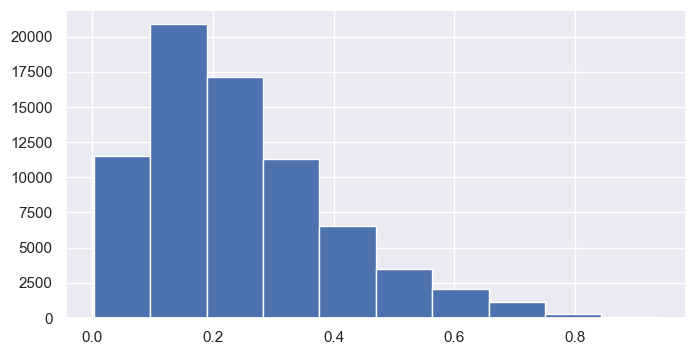

In [49]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = cat.predict_proba(test)[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('cat_solo.csv')